In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
train = pd.read_csv("https://raw.githubusercontent.com/dekpo23/Practice_datasets/refs/heads/main/home_loan_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/dekpo23/Practice_datasets/refs/heads/main/home_loan_test.csv")

In [4]:
train_copy = train.copy()

In [5]:
def data_cleaning(data):
    # missing values
    missing_cols = [x for x in data.columns if data[x].isna().any() == True]
    if len(missing_cols) > 0:
        print("Features with missing values")
        print(missing_cols)
        print(data.isna().sum())
        num_missing_cols = [x for x in missing_cols if data[x].dtype in ["int64", "float64"]]
        num_missing_cols.remove('Loan_Amount_Term')
        num_missing_cols.remove('Credit_History')
        obj_missing_cols = [x for x in missing_cols if x not in num_missing_cols]

        # Handle missing values in numerical features
        for i in num_missing_cols:
            median = data[i].median()
            data[i] = data[i].fillna(median)

        # Handle missing values in categorical features
        for i in obj_missing_cols:
            frequent = data[i].value_counts().index[0]
            data[i] = data[i].fillna(frequent)
        print(obj_missing_cols)
        print(num_missing_cols)
    else:
        print("No missing Values found")

    # Handling skewed data
    num_cols = [x for x in data.columns if data[x].dtype in ["int64", "float64"]]
    num_cols.remove('Loan_Amount_Term')
    num_cols.remove('Credit_History')
    obj_cols = [x for x in data.columns if x not in num_cols]

    print("Missing values count after Cleaning")
    print(data.isna().sum())

    # Apply log transform
    for i in num_cols:
        data[f"{i}_log"] = np.log1p(data[i])
    
    print("Skewness before cleaning")
    dic = {i: data[i].skew() for i in num_cols}
    print(dic)

    print("Skewness after cleaning")
    dic = {i: data[f"{i}_log"].skew() for i in num_cols}
    print(dic)
    
    return data


cleaned_data = data_cleaning(train_copy)



Features with missing values
['Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']
['LoanAmount']
Missing values count after Cleaning
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
Skewness before cleaning
{'ApplicantIncome': np.float64(6.539513113994625), 'Coapplican

In [6]:
cleaned_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y,8.674197,0.000000,4.859812
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,8.430327,7.319202,4.859812
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,8.006701,0.000000,4.204693
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,7.857094,7.765993,4.795791
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,8.699681,0.000000,4.955827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,7.972811,0.000000,4.276666
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,8.320448,0.000000,3.713572
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,8.996280,5.484797,5.537334
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,8.933796,0.000000,5.236442


In [7]:
def feature_engineering(data):
    # data = data.drop("Loan_ID", axis = 1)
    # Feature Engineering
    data["Loan_Income_Ratio"] = data["LoanAmount"] / data["ApplicantIncome"]
    data["Disposable_Income"] = data["ApplicantIncome"] - (data["LoanAmount"] / data["Loan_Amount_Term"])
    data['Income_Bin'] = pd.qcut(data['ApplicantIncome'], 5, labels=False)
    
    data["Income_Difference"] = data["ApplicantIncome"] - data["CoapplicantIncome"]
    kmeans_data = data[["ApplicantIncome", "CoapplicantIncome", "Credit_History", "Property_Area", "Loan_Amount_Term", "Dependents"]]
    num_pre_cols = [x for x in kmeans_data.columns if kmeans_data[x].dtype in ["int64", "float64"]]
    object_pre_cols = [x for x in kmeans_data.columns if x not in num_pre_cols]
    kmeans_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    kmeans_scaler = RobustScaler()
    cluster = KMeans(n_clusters=3)
    kmeans_data[object_pre_cols] = kmeans_encoder.fit_transform(kmeans_data[object_pre_cols])
    kmeans_data = pd.DataFrame(kmeans_scaler.fit_transform(kmeans_data), columns = kmeans_data.columns)
    pred = cluster.fit_predict(kmeans_data)
    data["Customer_cluster"] = pred

    
    return data

engineered_data = feature_engineering(cleaned_data)
engineered_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Loan_Income_Ratio,Disposable_Income,Income_Bin,Income_Difference,Customer_cluster
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y,8.674197,0.000000,4.859812,0.021884,5848.644444,3,5849.0,0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,8.430327,7.319202,4.859812,0.027929,4582.644444,3,3075.0,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,8.006701,0.000000,4.204693,0.022000,2999.816667,1,3000.0,0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,7.857094,7.765993,4.795791,0.046458,2582.666667,0,225.0,0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,8.699681,0.000000,4.955827,0.023500,5999.608333,3,6000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,7.972811,0.000000,4.276666,0.024483,2899.802778,1,2900.0,0
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,8.320448,0.000000,3.713572,0.009742,4105.777778,2,4106.0,1
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,8.996280,5.484797,5.537334,0.031343,8071.297222,4,7832.0,0
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,8.933796,0.000000,5.236442,0.024660,7582.480556,4,7583.0,0


In [8]:

def encoding(data):
    
    if "Loan_Status" not in data.columns:
        num_cols = [x for x in data.columns if data[x].dtype in ["int64", "float64"]]
        object_cols = [x for x in data.columns if x not in num_cols]
        encoder = joblib.load("encoder.pkl")
        scaler = joblib.load("scaler.pkl")
        data[object_cols] = encoder.transform(data[object_cols])
        data[num_cols] = scaler.transform(data[num_cols])
        return data
    else:
        data["Loan_Status"] = data["Loan_Status"].map({"N": 0, "Y": 1})
        X, y = data.drop("Loan_Status", axis = 1), data["Loan_Status"]
        num_cols = [x for x in X.columns if X[x].dtype in ["int64", "float64"]]
        object_cols = [x for x in X.columns if x not in num_cols]
        df_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X[object_cols] = df_encoder.fit_transform(X[object_cols])
        scaler = RobustScaler()
        X[num_cols] = scaler.fit_transform(X[num_cols])
        joblib.dump(df_encoder, "encoder.pkl")
        joblib.dump(scaler, "scaler.pkl")
        
        # Handling Class Imbalance
        sampling = SMOTE()
        X, y = sampling.fit_resample(X, y)
        X["Loan_Status"] = y
        return X

encoded_data = encoding(engineered_data)
encoded_data


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Loan_Income_Ratio,Disposable_Income,Income_Bin,Income_Difference,Customer_cluster,Loan_Status
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.698029,-0.517358,0.000000,0.0,0.000000,2.000000,0.611367,-0.914886,0.000000,-0.469962,0.698109,0.500000,0.764674,0.0,1
1,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.264096,0.139079,0.000000,0.0,0.000000,0.000000,0.262931,0.030760,0.000000,-0.155589,0.264152,0.500000,0.086972,0.0,0
2,2.000000,1.000000,1.000000,0.000000,0.000000,1.0,-0.278492,-0.517358,-0.961240,0.0,0.000000,2.000000,-0.342338,-0.914886,-1.329130,-0.463933,-0.278406,-0.500000,0.068650,0.0,1
3,3.000000,1.000000,1.000000,0.000000,1.000000,0.0,-0.421422,0.509087,-0.124031,0.0,0.000000,2.000000,-0.556094,0.088485,-0.129890,0.807946,-0.421396,-1.000000,-0.609296,0.0,1
4,4.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.749786,-0.517358,0.201550,0.0,0.000000,2.000000,0.647778,-0.914886,0.194798,-0.385928,0.749856,0.500000,0.801564,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,506.609477,1.000000,0.484360,0.484360,1.000000,0.0,0.001519,0.889414,-0.148749,0.0,0.000000,0.000000,-0.000840,0.098862,-0.182615,-0.004462,0.001570,0.000000,-0.521291,0.0,0
840,27.213562,1.000000,0.196610,0.196610,0.803390,0.0,-0.659199,-0.267022,-1.088268,0.0,0.000000,1.803390,-1.122649,-0.712142,-2.014846,-0.178598,-0.659126,-0.803390,-0.343198,0.0,0
841,33.225522,1.000000,0.445104,0.000000,0.000000,0.0,-0.425534,-0.259663,-0.657787,0.0,-0.445104,2.000000,-0.614313,-0.501193,-0.831512,0.332495,-0.425474,-0.722552,-0.180781,0.0,0
842,23.190562,1.000000,1.000000,1.809438,0.809438,0.0,-0.130393,0.400734,-0.132838,0.0,-0.809438,0.190562,-0.151263,0.072145,-0.154038,0.195605,-0.130350,-0.404719,-0.341051,0.0,0


Linear Model Metrics
Accuracy: 0.7218934911242604
Precision: 0.6761904761904762
Recall 0.8452380952380952
F1 0.7513227513227513


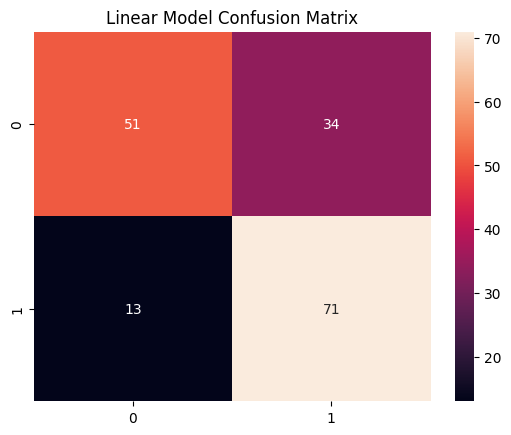

Decision Tree Model Metrics
Accuracy: 0.7928994082840237
Precision: 0.810126582278481
Recall 0.7619047619047619
F1 0.7852760736196319


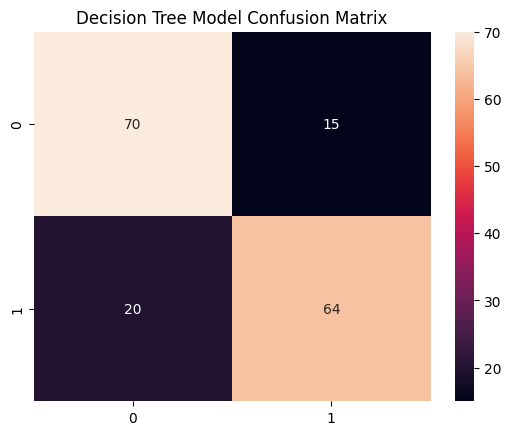



SVC Model Metrics
Accuracy: 0.47337278106508873
Precision: 0.4793388429752066
Recall 0.6904761904761905
F1 0.5658536585365853


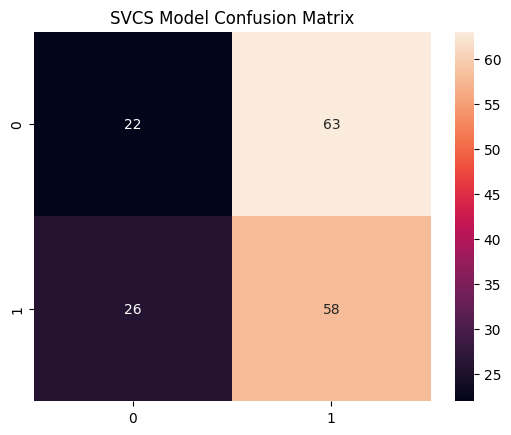



Random Forest Model Metrics
Accuracy: 0.8698224852071006
Precision: 0.8297872340425532
Recall 0.9285714285714286
F1 0.8764044943820225


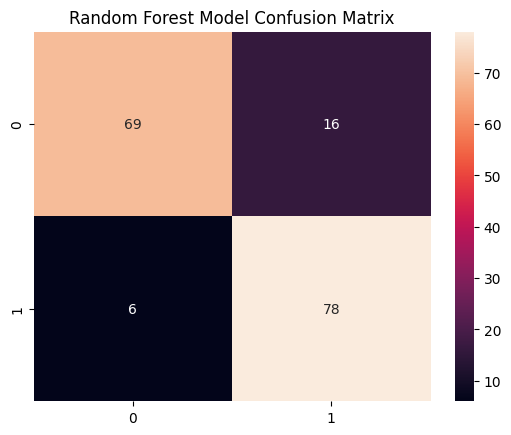



xgboost Model Metrics
Accuracy: 0.863905325443787
Precision: 0.8279569892473119
Recall 0.9166666666666666
F1 0.8700564971751412


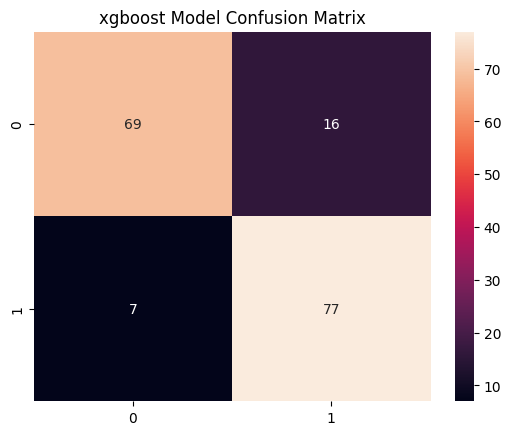



lightgbm Model Metrics
Accuracy: 0.8520710059171598
Precision: 0.8105263157894737
Recall 0.9166666666666666
F1 0.8603351955307262


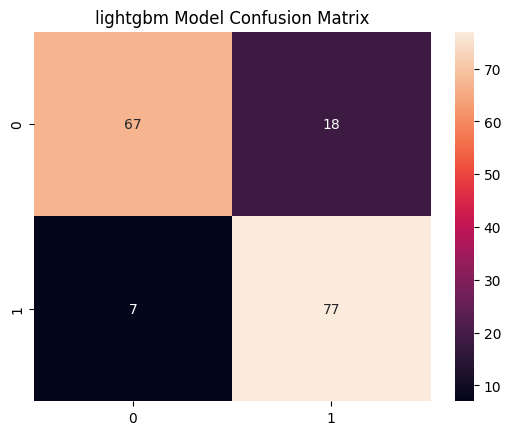

In [12]:
def modelling(data):
    if "Loan_Status" in data.columns:
        X, y = data.drop("Loan_Status", axis = 1), data["Loan_Status"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)
        linear_model = LogisticRegression(random_state=0)
        decision_tree = DecisionTreeClassifier(random_state=0)
        svcs = SVC(random_state=0)
        random_forest = RandomForestClassifier(random_state=0)
        xgboost = XGBClassifier(random_state = 0)
        lightgbm = LGBMClassifier(random_state=0)

        linear_pred = linear_model.fit(X_train, y_train)
        decision_pred = decision_tree.fit(X_train, y_train)
        svcs_pred = svcs.fit(X_train, y_train)
        random_forest_pred = random_forest.fit(X_train, y_train)
        xgboost_pred = xgboost.fit(X_train, y_train)
        lightgbm_pred = lightgbm.fit(X_train, y_train)

        linear_accuracy = accuracy_score(y_test, linear_pred.predict(X_test))
        linear_precision = precision_score(y_test, linear_pred.predict(X_test))
        linear_recall = recall_score(y_test, linear_pred.predict(X_test))
        linear_f1 = f1_score(y_test, linear_pred.predict(X_test))
        linear_confusion_matrix = confusion_matrix(y_test, linear_pred.predict(X_test))

        print("Linear Model Metrics")
        print("Accuracy:", linear_accuracy)
        print("Precision:", linear_precision)
        print("Recall", linear_recall)
        print("F1", linear_f1)
        plt.figure()
        sns.heatmap(linear_confusion_matrix, annot=True)
        plt.title("Linear Model Confusion Matrix")
        plt.show()

        decision_accuracy = accuracy_score(y_test, decision_pred.predict(X_test))
        decision_precision = precision_score(y_test, decision_pred.predict(X_test))
        decision_recall = recall_score(y_test, decision_pred.predict(X_test))
        decision_f1 = f1_score(y_test, decision_pred.predict(X_test))
        decision_confusion_matrix = confusion_matrix(y_test, decision_pred.predict(X_test))

        
        print("Decision Tree Model Metrics")
        print("Accuracy:", decision_accuracy)
        print("Precision:", decision_precision)
        print("Recall", decision_recall)
        print("F1", decision_f1)
        plt.figure()
        sns.heatmap(decision_confusion_matrix, annot=True)
        plt.title("Decision Tree Model Confusion Matrix")
        plt.show()


        svc_accuracy = accuracy_score(y_test, svcs_pred.predict(X_test))
        svc_precision = precision_score(y_test, svcs_pred.predict(X_test))
        svc_recall = recall_score(y_test, svcs_pred.predict(X_test))
        svc_f1 = f1_score(y_test, svcs_pred.predict(X_test))
        svc_confusion_matrix = confusion_matrix(y_test, svcs_pred.predict(X_test))
        print("\n")
        print("SVC Model Metrics")
        print("Accuracy:", svc_accuracy)
        print("Precision:", svc_precision)
        print("Recall", svc_recall)
        print("F1", svc_f1)
        plt.figure()
        sns.heatmap(svc_confusion_matrix, annot=True)
        plt.title("SVCS Model Confusion Matrix")
        plt.show()

        random_forest_accuracy = accuracy_score(y_test, random_forest_pred.predict(X_test))
        random_forest_precision = precision_score(y_test, random_forest_pred.predict(X_test))
        random_forest_recall = recall_score(y_test, random_forest_pred.predict(X_test))
        random_forest_f1 = f1_score(y_test, random_forest_pred.predict(X_test))
        random_forest_confusion_matrix = confusion_matrix(y_test, random_forest_pred.predict(X_test))
        print("\n")
        print("Random Forest Model Metrics")
        print("Accuracy:", random_forest_accuracy)
        print("Precision:", random_forest_precision)
        print("Recall", random_forest_recall)
        print("F1", random_forest_f1)

        plt.figure()
        sns.heatmap(random_forest_confusion_matrix, annot=True)
        plt.title("Random Forest Model Confusion Matrix")
        plt.show()


        xgboost_accuracy = accuracy_score(y_test, xgboost_pred.predict(X_test))
        xgboost_precision = precision_score(y_test, xgboost_pred.predict(X_test))
        xgboost_recall = recall_score(y_test, xgboost_pred.predict(X_test))
        xgboost_f1 = f1_score(y_test, xgboost_pred.predict(X_test))
        xgboost_confusion_matrix = confusion_matrix(y_test, xgboost_pred.predict(X_test))
        print("\n")
        print("xgboost Model Metrics")
        print("Accuracy:", xgboost_accuracy)
        print("Precision:", xgboost_precision)
        print("Recall", xgboost_recall)
        print("F1", xgboost_f1)

        plt.figure()
        sns.heatmap(xgboost_confusion_matrix, annot=True)
        plt.title("xgboost Model Confusion Matrix")
        plt.show()

        lightgbm_accuracy = accuracy_score(y_test, lightgbm_pred.predict(X_test))
        lightgbm_precision = precision_score(y_test, lightgbm_pred.predict(X_test))
        lightgbm_recall = recall_score(y_test, lightgbm_pred.predict(X_test))
        lightgbm_f1 = f1_score(y_test, lightgbm_pred.predict(X_test))
        lightgbm_confusion_matrix = confusion_matrix(y_test, lightgbm_pred.predict(X_test))
        print("\n")
        print("lightgbm Model Metrics")
        print("Accuracy:", lightgbm_accuracy)
        print("Precision:", lightgbm_precision)
        print("Recall", lightgbm_recall)
        print("F1", lightgbm_f1)

        plt.figure()
        sns.heatmap(lightgbm_confusion_matrix, annot=True)
        plt.title("lightgbm Model Confusion Matrix")
        plt.show()

    else:
        pass
        
modelling(encoded_data)
        


        

        